# **PRODIGY Task 4**

# **DATASET:**
[https://www.kaggle.com/gti-upm/leapgestrecog](https://www.kaggle.com/gti-upm/leapgestrecog)

### **Importing Required Libraries**

In [1]:
import os
import cv2
import numpy as np
from tqdm import tqdm
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Flatten, Dense, Dropout
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

### **Function to Load Images and Labels**

In [2]:
def load_images_and_labels(base_path):
    images = []
    labels = []

    for outer_folder in range(10):
        outer_folder_path = os.path.join(base_path, f"{outer_folder:02d}")

        # Check if the outer folder exists
        if not os.path.exists(outer_folder_path):
            print(f"Folder {outer_folder_path} does not exist.")
            continue

        # Iterate over the inner folders which have the label names
        for label_folder in os.listdir(outer_folder_path):
            label_folder_path = os.path.join(outer_folder_path, label_folder)

            # Extract the numeric part of the label folder name
            try:
                label = int(label_folder.split('_')[0])
            except ValueError:
                print(f"Skipping folder {label_folder} as it does not have a valid numeric label.")
                continue

            # Load each image inside the label folder
            for image_file in tqdm(os.listdir(label_folder_path), desc=f"Loading images from {label_folder}"):
                image_path = os.path.join(label_folder_path, image_file)

                # Read the image using OpenCV
                image = cv2.imread(image_path)
                if image is not None:

                    image = cv2.resize(image, (64, 64))
                    images.append(image)
                    labels.append(label)  # Use the extracted label

    # Convert lists to numpy arrays
    images = np.array(images, dtype='float32') / 255.0  # Normalize pixel values to [0, 1]
    labels = np.array(labels, dtype='int')

    return images, labels

### **Data Loading and Preprocessing**

In [3]:
base_path = '/content/drive/MyDrive/Colab Notebooks/internship/leapGestRecog'

# Load images and labels
images, labels = load_images_and_labels(base_path)

print(f"Total images loaded: {len(images)}")
print(f"Total labels loaded: {len(labels)}")

Loading images from 09_c: 100%|██████████| 200/200 [00:04<00:00, 45.41it/s] 


Total images loaded: 20000
Total labels loaded: 20000


In [4]:
labels = labels - 1

print(f"Unique labels after adjustment: {np.unique(labels)}")

Unique labels after adjustment: [0 1 2 3 4 5 6 7 8 9]


### **Split the data into training, validation, and testing sets**

In [5]:
X_train, X_temp, y_train, y_temp = train_test_split(images, labels, test_size=0.3, random_state=42, stratify=labels)

In [6]:
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

In [7]:
print(f"Training data shape: {X_train.shape}, Training labels shape: {y_train.shape}")
print(f"Validation data shape: {X_val.shape}, Validation labels shape: {y_val.shape}")
print(f"Testing data shape: {X_test.shape}, Testing labels shape: {y_test.shape}")

Training data shape: (14000, 64, 64, 3), Training labels shape: (14000,)
Validation data shape: (3000, 64, 64, 3), Validation labels shape: (3000,)
Testing data shape: (3000, 64, 64, 3), Testing labels shape: (3000,)


### **Data Augmentation**

In [8]:
# Create an instance of ImageDataGenerator for augmentation
data_augmentation = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Fit the data generator on the training data
data_augmentation.fit(X_train)

In [9]:
train_generator = data_augmentation.flow(X_train, y_train, batch_size=32)

In [10]:
test_data_gen = ImageDataGenerator()
test_generator = test_data_gen.flow(X_test, y_test, batch_size=32)

In [11]:
val_augmentation = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_augmentation.fit(X_val)

val_generator = val_augmentation.flow(X_val, y_val, batch_size=32)

### **Model Architecture Definition**

In [ ]:
def create_model(input_shape,num_classes):
    model = Sequential([
        tf.keras.Input(shape=input_shape),
        Conv2D(filters=32, kernel_size=(3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),

        Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),

        Conv2D(filters=128, kernel_size=(3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),

        Flatten(),
        Dense(units=256, activation='relu'),
        Dropout(0.5),

        Dense(units=128, activation='relu'),
        Dropout(0.5),

        Dense(units=num_classes, activation='softmax')
    ])
    return model

In [ ]:
input_shape = (64, 64, 3)
num_classes = len(np.unique(labels))

model = create_model(input_shape, num_classes)

In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 62, 62, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 62, 62, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 31, 31, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 29, 29, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 29, 29, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 12, 12, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 12, 12, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 6, 6, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 4608)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │       1,179,904 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 10)                  │           1,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,308,234 (4.99 MB)

 Trainable params: 1,307,786 (4.99 MB)

 Non-trainable params: 448 (1.75 KB)

### **Model Compilation and Training**

In [ ]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
checkpoint = ModelCheckpoint('best_model.keras', monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)
early_stopping = EarlyStopping(monitor='val_accuracy', patience=6, restore_best_weights=True, mode='max', verbose=1)

In [ ]:
history = model.fit(
    train_generator,
    epochs=20,
    batch_size=32,
    validation_data=val_generator,
    callbacks=[checkpoint, early_stopping]
)

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


438/438 ━━━━━━━━━━━━━━━━━━━━ 0s 405ms/step - accuracy: 0.1164 - loss: 2.9820
Epoch 1: val_accuracy improved from -inf to 0.18500, saving model to best_model.keras
438/438 ━━━━━━━━━━━━━━━━━━━━ 197s 435ms/step - accuracy: 0.1164 - loss: 2.9808 - val_accuracy: 0.1850 - val_loss: 2.1749
Epoch 2/20
438/438 ━━━━━━━━━━━━━━━━━━━━ 0s 405ms/step - accuracy: 0.1851 - loss: 2.1735
Epoch 2: val_accuracy improved from 0.18500 to 0.25700, saving model to best_model.keras
438/438 ━━━━━━━━━━━━━━━━━━━━ 190s 433ms/step - accuracy: 0.1851 - loss: 2.1734 - val_accuracy: 0.2570 - val_loss: 2.0194
Epoch 3/20
438/438 ━━━━━━━━━━━━━━━━━━━━ 0s 408ms/step - accuracy: 0.2492 - loss: 1.9916
Epoch 3: val_accuracy improved from 0.25700 to 0.35700, saving model to best_model.keras
438/438 ━━━━━━━━━━━━━━━━━━━━ 192s 437ms/step - accuracy: 0.2493 - loss: 1.9914 - val_accuracy: 0.3570 - val_loss: 1.6509
Epoch 4/20
438/438 ━━━━━━━━━━━━━━━━━━━━ 0s 415ms/step - accuracy: 0.3557 - loss: 1.6867
Epoch 4: val_accuracy improved f

### **Model Evaluation on Test Data**

In [28]:
# Evaluate the model on the test data
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test accuracy: {test_accuracy:.4f}")

94/94 ━━━━━━━━━━━━━━━━━━━━ 9s 92ms/step - accuracy: 0.9956 - loss: 0.0140
Test accuracy: 0.9957


### **Visualization of Training Process**

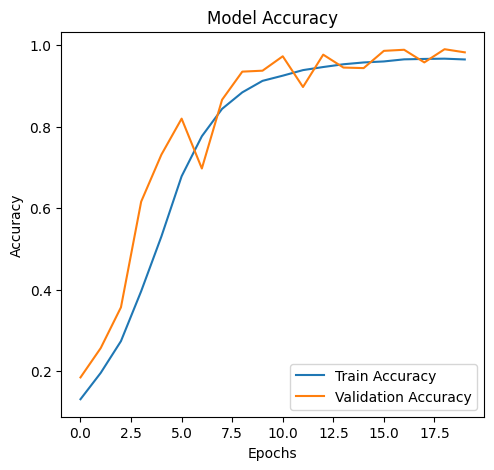

In [ ]:
# Plot accuracy and loss
plt.figure(figsize=(12, 5))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

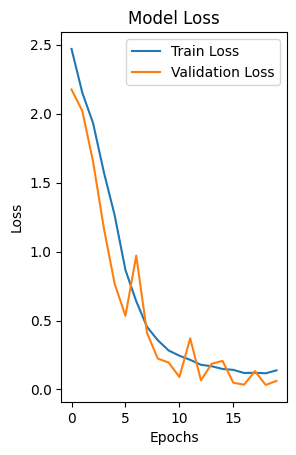

In [ ]:
# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

In [ ]:
class_names = ['Palm', 'l', 'fist', 'fist_moved', 'thumb', 'index', 'ok', 'palm_moved', 'c', 'down']

# Compute predictions
y_pred = np.argmax(model.predict(X_test), axis=-1)

94/94 ━━━━━━━━━━━━━━━━━━━━ 6s 65ms/step


### **Confusion Matrix and Classification Report**

<Figure size 1200x800 with 0 Axes>

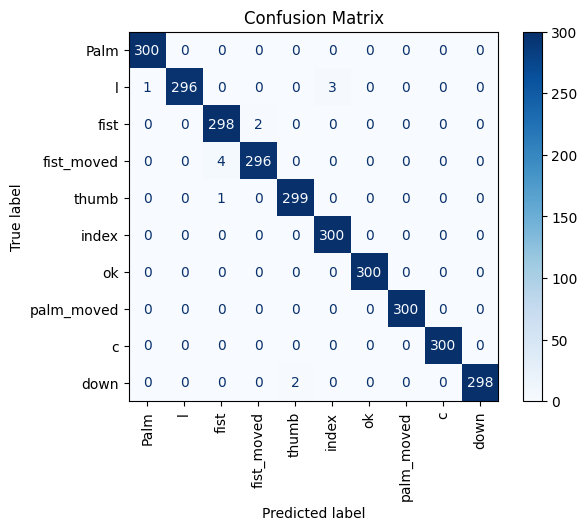

In [ ]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Create a wider figure for the confusion matrix
plt.figure(figsize=(12, 8))  # Adjust the width and height as needed
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.xticks(rotation=90)  # Rotate x-axis labels for better visibility
plt.show()

In [ ]:
report = classification_report(y_test, y_pred, target_names=class_names)
print("Classification Report:\n", report)

Classification Report:
               precision    recall  f1-score   support

        Palm       1.00      1.00      1.00       300
           l       1.00      0.99      0.99       300
        fist       0.98      0.99      0.99       300
  fist_moved       0.99      0.99      0.99       300
       thumb       0.99      1.00      1.00       300
       index       0.99      1.00      1.00       300
          ok       1.00      1.00      1.00       300
  palm_moved       1.00      1.00      1.00       300
           c       1.00      1.00      1.00       300
        down       1.00      0.99      1.00       300

    accuracy                           1.00      3000
   macro avg       1.00      1.00      1.00      3000
weighted avg       1.00      1.00      1.00      3000



### **Display Random Test Images with Prediction**

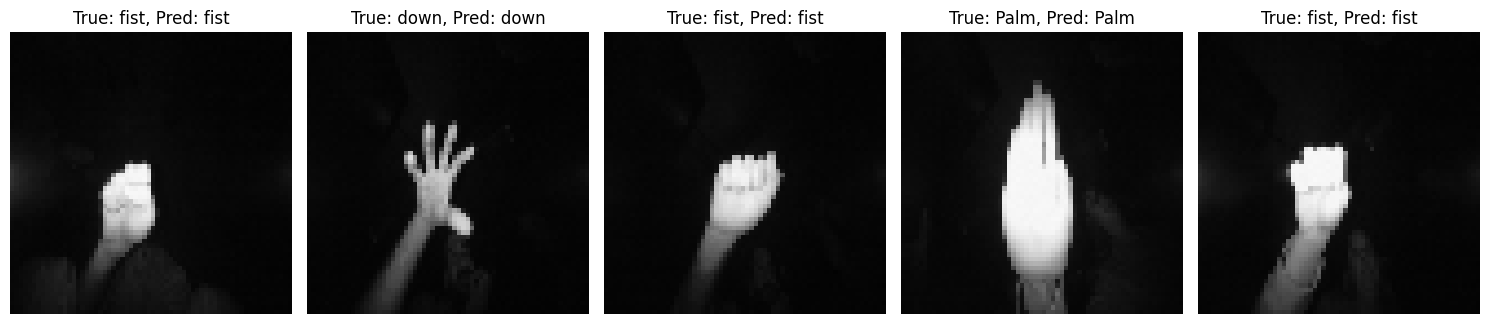

In [ ]:
# Display 5 random test images with true and predicted labels
num_images_to_display = 5
random_indices = np.random.choice(len(X_test), num_images_to_display, replace=False)

plt.figure(figsize=(15, 5))

for i in range(num_images_to_display):
    plt.subplot(1, num_images_to_display, i + 1)
    plt.imshow(X_test[random_indices[i]])
    plt.title(f'True: {class_names[y_test[random_indices[i]]]}, Pred: {class_names[y_pred[random_indices[i]]]}')
    plt.axis('off')

plt.tight_layout()
plt.show()

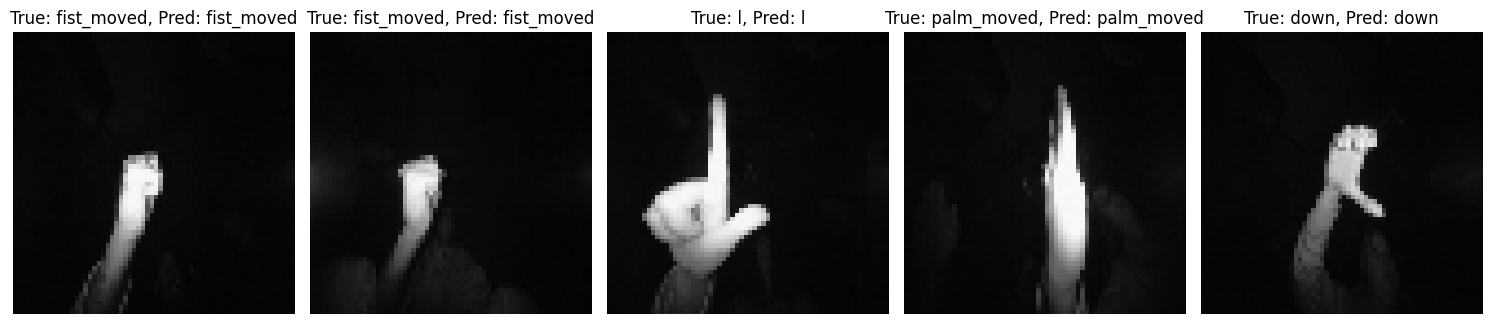

In [ ]:
# Display 5 random test images with true and predicted labels
num_images_to_display = 5
random_indices = np.random.choice(len(X_test), num_images_to_display, replace=False)

plt.figure(figsize=(15, 5))

for i in range(num_images_to_display):
    plt.subplot(1, num_images_to_display, i + 1)
    plt.imshow(X_test[random_indices[i]])
    plt.title(f'True: {class_names[y_test[random_indices[i]]]}, Pred: {class_names[y_pred[random_indices[i]]]}')
    plt.axis('off')

plt.tight_layout()
plt.show()

# **Conclusion**
The hand gesture recognition model achieved exceptional performance across all evaluation metrics, demonstrating its ability to accurately classify different hand gestures:

**High Overall Accuracy:** The model reached a test accuracy of 99.57%, indicating that it correctly classified nearly all test images.

**Classification Metrics:** Precision, recall, and F1-score for all gesture classes were consistently high (close to 1.00), indicating both minimal false positives and false negatives. This consistency across gesture categories suggests that the model effectively handles variations in hand poses.

**Class-specific Performance:** The classification report showed that most gestures had an F1-score of 1.00, with only a few minor variations in precision and recall for certain classes (e.g., 'fist' and 'down'), which still maintained scores of 0.98 or above.